In [1]:
import jax.numpy as jnp
import jax.random as jr
import optimistix as optx


# TODO: which problem is this? ZECEVIC?
def objective(x, args):
    num_vars = x.size
    fractions = 2 * jnp.arange(1, num_vars + 1) / num_vars
    return jnp.sum((x - fractions) ** 2)


def constraint(x):
    return jnp.sum(x) - 1, None


x0 = jr.normal(jr.key(0), (10,))
x0 = jnp.abs(x0)
x0 = x0 / jnp.sum(x0)
# Note: I seem to have a bug that I get when the starting value is
# [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# This one seems to be about NaN / inf input, so its likely a problem in the descent
# formulation

# I also identified another bug - it looks like feasibility restoration gets called even
# though we're inside the bounds and the constraint is satisfied. Then it returns the
# same value, which triggers another call to the feasibility restoration. I don't know
# why it gets called from there in the first place? But this should not happen, this is
# not the purpose of the feasibility restoration, and it can't work with the way it is
# formulated.
# I think this could be because I don't yet adapt the barrier parameters? If I then use
# a tolerance that is smaller than the barrier parameter, then it has an impossible task
# and that could be the cause of the doom loop.

bounds = jnp.full_like(x0, 0.0), jnp.full_like(x0, jnp.inf)

solver = optx.IPOPTLike(rtol=1e-3, atol=1e-3)

sol = optx.minimise(objective, solver, x0, constraint=constraint, bounds=bounds)

sol.stats["num_steps"]

Array(6, dtype=int32, weak_type=True)

In [2]:
[
    0.19444433577680922,
    0.09374991349153455,
    2.4968709227545733e-7,
    1.6406490435664459e-9,
    -3.9858110142065675e-9,
    -5.9455025440355135e-9,
    -6.9419482480851566e-9,
    -7.545237238875595e-9,
    -7.949714836034365e-9,
    0.7118055317721288,
]

[0.19444433577680922,
 0.09374991349153455,
 2.4968709227545733e-07,
 1.6406490435664459e-09,
 -3.9858110142065675e-09,
 -5.9455025440355135e-09,
 -6.9419482480851566e-09,
 -7.545237238875595e-09,
 -7.949714836034365e-09,
 0.7118055317721288]

In [3]:
sol.value

Array([0.00378807, 0.00446065, 0.00544954, 0.00693434, 0.00964255,
       0.0151272 , 0.03467718, 0.12575287, 0.30034247, 0.4938251 ],      dtype=float32)

In [4]:
x0

Array([0.20507355, 0.255958  , 0.05479874, 0.00993586, 0.02225481,
       0.12285506, 0.06259709, 0.0624808 , 0.08396212, 0.12008402],      dtype=float32)

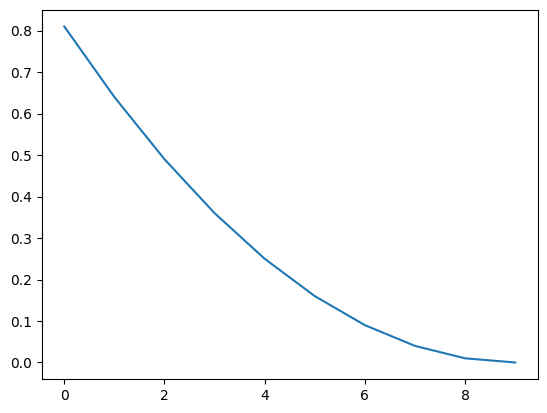

In [5]:
import matplotlib.pyplot as plt


x = jnp.ones(10)
n = x.size

y = (x - jnp.arange(1, n + 1) / n) ** 2

plt.plot(jnp.arange(n), y)

In [6]:
# BIGGSC4
# https://doi.org/10.1016/0165-1889(94)90075-2, page 190
def objective(y, args):
    del args
    x1, x2, x3, x4 = y
    return -x1 * x3 - x2 * x4


def constraint(y):
    x1, x2, x3, x4 = y
    cl1 = x1 + x2
    cu1 = 5 - x1 + x2
    cl2 = x1 + x3
    cu2 = 5 - x1 + x3
    cl3 = x1 + x4
    cu3 = 5 - x1 + x4
    cl4 = x2 + x3
    cu4 = 4.5 - x2 + x3
    cl5 = x2 + x4 - 0.5
    cu5 = 4.5 - x2 + x4
    cl6 = x3 + x4 - 1
    cu6 = 4 - x3 + x4
    cl7 = x1 + x2 + x3 + x4 - 5
    constraints = [cl1, cu1, cl2, cu2, cl3, cu3, cl4, cu4, cl5, cu5, cl6, cu6, cl7]
    return None, jnp.asarray(constraints)


# Bounds
bounds = jnp.full_like(x0, 0.0), jnp.full_like(x0, 5.0)

# Initial guess
x0 = jnp.ones(4)

# Expected solution according to the SIF collection:
expected_results = -24.5  # TODO: is this the objective value?

solver = optx.InteriorPoint(rtol=1e-3, atol=1e-6)

sol = optx.quadratic_solve(objective, solver, jnp.ones(4), constraint=constraint)
sol.value, objective(sol.value, None)

(Array([2.1939378, 1.6828063, 1.9029938, 1.4086837], dtype=float32),
 Array(-6.5455914, dtype=float32))

In [7]:
# BIGGSB1
# https://doi.org/10.1016/0165-1889(94)90075-2, page 188 (I think)
# Looks like Example 1 but I'm not sure that is correct given the SIF file? The latter
# only mentions an object lower bound, but that appears to be the lower bound on the
# variables.


def objective(y, args):
    del args

    value = (y[0] - 1) ** 2
    for i in range(1, y.size - 1):
        value += (y[i] - y[i - 1]) ** 2
    value += (y[-1] - 1) ** 2

    return value


def constraint(y):  # dummy constraint
    return jnp.array(0.0), jnp.array(0.0)


# Initial value
x0 = 0.5 * jnp.ones(25)

# BOUNDS
#  UP BIGGSB1   'DEFAULT' 0.9
#  XR BIGGSB1   X(N)
# OBJECT BOUND
#  LO BIGGSB1             0.0
# (A little further down this "object bound" is mentioned.)
lower_bound = jnp.full_like(x0, 0.0)
lower_bound = lower_bound.at[-1].set(-jnp.inf)
upper_bound = jnp.full_like(x0, 0.9)
upper_bound = upper_bound.at[-1].set(jnp.inf)
bounds = (lower_bound, upper_bound)

# *   Solution
# *LO BIGGSB1             0.015
expected_result = 0.015


solver = optx.BFGS_B(rtol=1e-6, atol=1e-9)
sol = optx.minimise(objective, solver, x0, bounds=bounds)

sol.value, objective(sol.value, None), expected_result

(Array([0.9       , 0.77094436, 0.6170027 , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.9856719 ],      dtype=float32),
 Array(0.06424832, dtype=float32),
 0.015)

15.811628960000002
4.04 [-25. -21.  -4.]


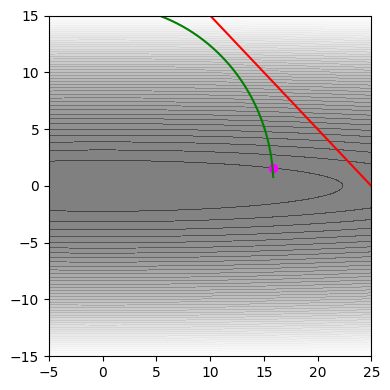

In [8]:
import jax.numpy as jnp
import matplotlib.pyplot as plt


# BT12
# https://www.jstor.org/stable/2157674?seq=21, page 622
# It looks like this problem does not have a feasible solution, based on the projection
# below and the documented expected result.


def objective(y, args):
    x1, x2, *_ = y
    return 0.01 * x1**2 + x2**2


def constraint(y):
    x1, x2, x3, x4, x5 = y
    c1 = x1 + x2 - x3**2 - 25  # x2 = 25 - x1 + x3**2
    c2 = x1**2 + x2**2 - x4**2 - 25  # x2**2 = sqrt(25 + x4**2 - x1**2)
    c3 = x1 - x5**2 - 2  # x1 = 2 + x5**2
    return jnp.array([c1, c2, c3])


y0 = 2 * jnp.ones(5)
expected_result = jnp.array([15.811, 1.5811, 0, 15.083, 3.7164])

print(2 + 3.7164**2)

print(objective(y0, None), constraint(y0))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))


def _wrapped(y):
    return objective(y, None)


def c1_zero(x1):
    return 25 - x1  # - x3**2, but x3 = 0 at the solution


def c2_zero(x1):
    return jnp.sqrt(25 + 15.083**2 - x1**2)


x = jnp.linspace(-5, 25, 1000)
y = jnp.linspace(-15, 15, 1000)
X, Y = jnp.meshgrid(x, y)
Z = _wrapped((X, Y))
ax.contourf(X, Y, Z, levels=50, cmap="Grays_r", alpha=0.5)

ax.plot(x, c1_zero(x), color="red")
ax.plot(x, c2_zero(x), color="green")

ax.scatter(*expected_result[:2], color="magenta")

# Layout
ax.set_ylim(-15, 15)
fig.tight_layout()